In [30]:
import ROOT as r
import numpy as np
import os
import matplotlib.pyplot as plt

workDir = '/mnt/c/users/llave/Documents/CMS/'
#workDir = 'c:/users/llave/Documents/CMS/'
fin = r.TFile(workDir + 'images_DYJets50.root')
tree = fin.Get('trackImageAnalyzer/tree')

# dEta -0.5 to 0.5
# dPhi -3.5 to 0.5

def convert_eta(eta):
	return int((eta + 0.5)*40/2)

def convert_phi(phi):
	return int((phi*10+35)/2)

In [31]:
#ids of GEN particles
ids = set([abs(x.genMatchedID) for x in tree])
print(ids)
print(len(ids))

{0, 321, 130, 2112, 2212, 3112, 11, 12, 13, 14, 16, 3122, 211, 22, 3222, 310, 3322}
17


In [41]:
m = [[0,0],[0,0]]
dist_match,dist_disc=[],[]
match_id,no_match_id=[],[]
lep,bkg = [],[]
c1,c2 = 0,0
for iTrack, track in enumerate(tree):
    if(abs(track.genMatchedID)!=11): continue
        
    #lepton events where the RECO failed 
    if(track.deltaRToClosestElectron > 0.1 or track.deltaRToClosestElectron == -1):
        
        #is the trach from leptons or not?
        if(abs(track.genMatchedDR) < 0.1): 
            lep.append(iTrack)
            c1+=1
        elif(abs(track.genMatchedDR) > 0.1): 
            bkg.append(iTrack)
            c2+=1
    
    # divide by whether there is match with RECO electron and track
    if(abs(track.genMatchedDR < 0.1)):
        dist_match.append(track.deltaRToClosestElectron)
        if(abs(track.deltaRToClosestElectron) < 0.1):
            m[0][0]+=1
            match_id.append(iTrack)
        else:
            m[0][1]+=1
    if(abs(track.genMatchedDR) > 0.1):
        dist_disc.append(track.deltaRToClosestElectron)
        if(abs(track.deltaRToClosestElectron) < 0.1):
            m[1][0]+=1
        else:
            m[1][1]+=1
            no_match_id.append(iTrack)

print("\t\t\ttrack/RECO match")
print("\t\t\ttrue \t false")
print('track/GEN match')
row_title = ['true','false']
for i,row in enumerate(m):
    print(row_title[i],end='\t\t\t')
    for elm in row:
        print(elm, end = '\t')
    print()
    
print()
print(c1,c2)
print()

			track/RECO match
			true 	 false
track/GEN match
true			1555	97	
false			5	1007	

97 1007



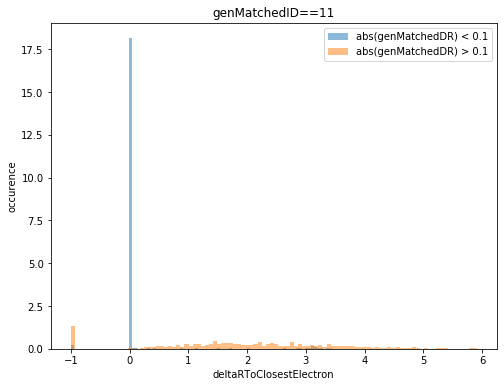

In [49]:
plt.figure(figsize=(8,6))
plt.hist(dist_match,alpha=0.5,label='abs(genMatchedDR) < 0.1',density=True,bins=100)
plt.hist(dist_disc,alpha=0.5,label='abs(genMatchedDR) > 0.1',density=True,bins=100)
plt.title('genMatchedID==11')
plt.ylabel('occurence')
plt.xlabel('deltaRToClosestElectron')
plt.legend()
plt.savefig('deltaR_e.png',quality=80)
plt.show()

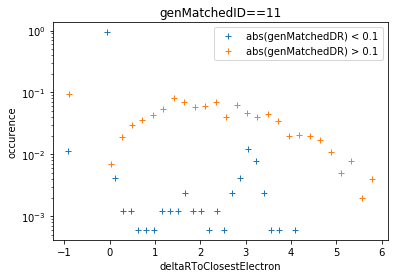

In [21]:
counts1,bin_edges1 = np.histogram(dist_match,30)
counts2,bin_edges2 = np.histogram(dist_disc,30)
bin_centers1 = (bin_edges1[:-1] + bin_edges1[1:])/2.
bin_centers2 = (bin_edges2[:-1] + bin_edges2[1:])/2.
sum1 = np.sum(counts1)
sum2 = np.sum(counts2)
counts1 = np.array([x/sum1 for x in counts1])
counts2 = np.array([x/sum2 for x in counts2])
plt.errorbar(bin_centers1, counts1, fmt='+',label='abs(genMatchedDR) < 0.1')
plt.errorbar(bin_centers2, counts2, fmt='+',label='abs(genMatchedDR) > 0.1')
plt.title('genMatchedID==11')
plt.ylabel('occurence')
plt.xlabel('deltaRToClosestElectron')
plt.legend()
plt.yscale('log')
plt.show()

In [29]:
fin2 = r.TFile(workDir + 'images_DYJets50_norm.root')
newtree = fin2.Get('tree')

events_e,events_bkg = [],[]

for iTrack, track in enumerate(newtree):	

    #debug
#     if iTrack != 1: continue
#     print(track.recHits_dPhi)
#     print(track.recHits_dEta)
#     print(track.recHits_detType)
            
    nHits = len(track.recHits_detType)
        
    matrix_ECAL = np.zeros([20,20])
    matrix_HCAL = np.zeros([20,20])
    matrix_mouns = np.zeros([20,20])  
    
    if(abs(track.genMatchedID)!=11): continue
        
    lepton,background = False,False
    
    #lepton events where the RECO failed 
    if(track.deltaRToClosestElectron > 0.1 or track.deltaRToClosestElectron == -1):
        
        #is the trach from leptons or not?
        if(abs(track.genMatchedDR) < 0.1): lepton = True
        elif(abs(track.genMatchedDR) > 0.1): background = True
        
    dEta_ECAL = np.array([convert_eta(x) for i,x in enumerate(track.recHits_dEta) if track.recHits_detType[i]==1])
    dEta_HCAL = np.array([convert_eta(x) for i,x in enumerate(track.recHits_dEta) if track.recHits_detType[i]==2])
    dPhi_ECAL = np.array([convert_phi(x) for i,x in enumerate(track.recHits_dPhi) if track.recHits_detType[i]==1])
    dPhi_HCAL = np.array([convert_phi(x) for i,x in enumerate(track.recHits_dPhi) if track.recHits_detType[i]==2])
    energy_ECAL = np.array([x for i,x in enumerate(track.recHits_energy) if track.recHits_detType[i]==1])
    energy_HCAL = np.array([x for i,x in enumerate(track.recHits_energy) if track.recHits_detType[i]==2])

    if(len(dEta_ECAL)!=0 and len(dPhi_ECAL)!=0): matrix_ECAL[dEta_ECAL,dPhi_ECAL] = energy_ECAL
    if(len(dEta_HCAL)!=0 and len(dPhi_HCAL)!=0): matrix_HCAL[dEta_HCAL,dPhi_HCAL] = energy_HCAL

    if lepton: events_e.append(np.stack([matrix_ECAL,matrix_HCAL,matrix_mouns],axis = -1))
    if background: events_bkg.append(np.stack([matrix_ECAL,matrix_HCAL,matrix_mouns],axis = -1))

np.save(workDir+'e_DYJets50_norm_20x20', events_e)
np.save(workDir+'bkg_DYJets50_norm_20x20', events_bkg)

Warning in <TFile::Init>: file /mnt/c/users/llave/Documents/CMS/images_DYJets50_norm.root probably not closed, trying to recover
Info in <TFile::Recover>: /mnt/c/users/llave/Documents/CMS/images_DYJets50_norm.root, recovered key TTree:tree at address 11333044
Warning in <TFile::Init>: successfully recovered 1 keys


In [22]:
def plot_event(eventNum):
    
    x = events[eventNum]
    
    fig, axs = plt.subplots(1,3,figsize=(10,10))
    
    for i in range(3):
        axs[i].imshow(x[:,:,i],cmap='gray')
    
    axs[0].set_title("ECAL")
    axs[1].set_title("HCAL")
    axs[2].set_title("Muon")
    
    plt.show()

plot_event(50)

NameError: name 'events' is not defined

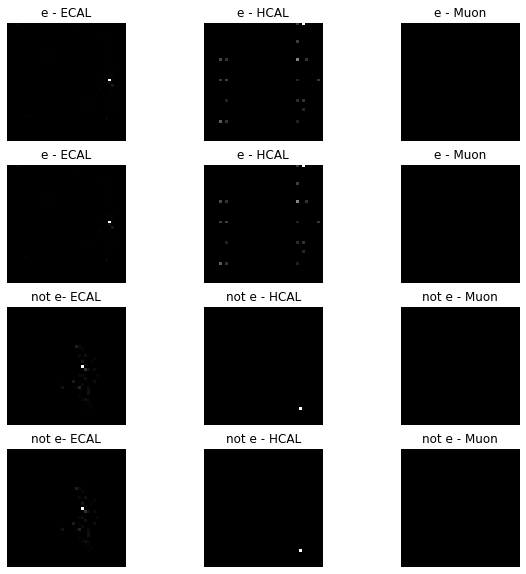

In [14]:
x = events[lep[np.random.randint(0,len(lep))]]
y = events[bkg[np.random.randint(0,len(bkg))]]
    
fig, axs = plt.subplots(4,3,figsize=(10,10))

for j in range(4):
    if j < 2:
        axs[j,0].set_title("e - ECAL")
        axs[j,1].set_title("e - HCAL")
        axs[j,2].set_title("e - Muon")
    else:
        axs[j,0].set_title("not e- ECAL")
        axs[j,1].set_title("not e - HCAL")
        axs[j,2].set_title("not e - Muon")
    for i in range(3):
        axs[j,i].axis('off')
        if j < 2:
            axs[j,i].imshow(x[:,:,i],cmap='gray')
        else:
            axs[j,i].imshow(y[:,:,i],cmap='gray')
fig.savefig("comp.png")